# Аналитика в Яндекс.Афише

Задача — помочь маркетологам оптимизировать маркетинговые затраты. В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Шаг 1. Предобработка данных

Загружаем необходимые библиотеки.

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

Импортируем данные.

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

### Посещения сайта

Более подробно рассмотрим каждый из файлов. Начнем с данных о посещениях сайта.

In [3]:
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06


Сделаем названия колонок во всех таблицах более единообразным. Приведем все буквы к строчным, пробелы заменим на подчеркивания.

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

Убедимся в том, что в таблице нет пропусков. Одновременно выясним тип данных в столбцах.

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        358532 non-null  uint64
 1   device     358532 non-null  object
 2   end_ts     358532 non-null  object
 3   source_id  358532 non-null  int64 
 4   start_ts   358532 non-null  object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Меняем порядок вывода столбцов для большей наглядности.

In [6]:
visits = visits[['uid', 'start_ts', 'end_ts', 'device', 'source_id']]
visits.head()

,uid,start_ts,end_ts,device,source_id
0,16879256277535980062,20.12.2017 17:20,20.12.2017 17:38,touch,4
1,104060357244891740,19.02.2018 16:53,19.02.2018 17:21,desktop,2
2,7459035603376831527,01.07.2017 1:54,01.07.2017 1:54,touch,5
3,16174680259334210214,20.05.2018 10:59,20.05.2018 11:23,desktop,9
4,9969694820036681168,27.12.2017 14:06,27.12.2017 14:06,desktop,3


Меняем тип данных там, где это необходимо, а именно в  двух столбцах, содержащих информацию о времени / датах.

In [7]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%d.%m.%Y %H:%M')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%d.%m.%Y %H:%M')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        358532 non-null  uint64        
 1   start_ts   358532 non-null  datetime64[ns]
 2   end_ts     358532 non-null  datetime64[ns]
 3   device     358532 non-null  object        
 4   source_id  358532 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Проверяем на наличие грубых дубликатов.

In [8]:
visits.duplicated().sum()

0

### Заказы

Более подробно рассмотрим таблицу, содержащую информацию о заказах, сделанных через сервис Яндекс.Афиша. 

In [9]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Как и в предыдущем случае, заменим названия колонок. Убедимся в том, что в таблице нет пропусков.

In [10]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Изменим порядок вывода столбцов.

In [11]:
orders = orders[['uid', 'buy_ts', 'revenue']]
orders.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01 00:10:00,17.00
1,11627257723692907447,2017-06-01 00:25:00,0.55
2,17903680561304213844,2017-06-01 00:27:00,0.37
3,16109239769442553005,2017-06-01 00:29:00,0.55
4,14200605875248379450,2017-06-01 07:58:00,0.37


Приведем столбец со временем покупки к типу данных datetime64.

In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   uid      50415 non-null  uint64        
 1   buy_ts   50415 non-null  datetime64[ns]
 2   revenue  50415 non-null  float64       
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Проверяем на наличие грубых дубликатов.

In [13]:
orders.duplicated().sum()

0

### Рекламные расходы

Взглянем на таблицу, в которой содержится информация о маркетинговых расходах.

In [14]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Проверяем на наличие пропусков, оцениваем корректность выбора типа данных.

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Заменяем тип данных на необходимый в столбце 'dt'.

In [16]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Проверяем на наличие грубых дубликатов.

In [17]:
costs.duplicated().sum()

0

### Вывод для шага 1

На этапе предобработки мы загрузили данные и проверили их на наличие пропусков и корректность выбранных типов данных. Пропусков не обнаружено, а вот тип данных во всех столбцах связанных с датой и временем всех трех таблиц изменили с object на datetime64. Дубликатов не обнаружено. Данные хорошо структурированы, с ними удобно работать.

## Шаг 2. Расчеты и метрики

### Продукт

На данном этапе рассчитаем основные метрики, такие как DAU, WAU, MAU, LTV, CAC и ROI. Там, где это уместно, посмотрим на эти показатели в разбивке по месяцам, источникам трафика и платформам.

#### *Сколько людей пользуются в день, неделю, месяц?*

Добавим столбцы с годом, датой, неделей и месяцем посещения сайта.

In [18]:
visits['year'] = visits['start_ts'].dt.year
visits['day'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits.head(3)

,uid,start_ts,end_ts,device,source_id,year,day,week,month
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,2017,2017-12-20,51,12
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,2018,2018-02-19,8,2
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,touch,5,2017,2017-07-01,26,7


Рассчитаем DAU, количество ежедневных пользователей.

In [19]:
dau = visits.groupby('day').agg({'uid':'nunique'}).mean()
print('Количество ежедневных пользователей:', int(dau))

Количество ежедневных пользователей: 907


Количество ежедневных пользователей по платформам:

In [20]:
daily_users_device = visits.groupby(['device', 'day']).agg({'uid':'nunique'}).reset_index()
daily_users_device_df = daily_users_device.groupby('device')['uid'].mean().reset_index()
daily_users_device_df.columns = ['device', 'user_count']
daily_users_device_df

,device,user_count
0,desktop,659.217033
1,touch,252.834711


Рассчитаем процентное соотношение пользовательских платформ.

In [21]:
daily_users_device_df['pct'] = ((daily_users_device_df['user_count'] / daily_users_device_df['user_count'].sum()) * 100).round(1)
daily_users_device_df

,device,user_count,pct
0,desktop,659.217033,72.3
1,touch,252.834711,27.7


Видим, что почти 3/4 всех пользователей пользуются сервисом со стационарных ПК и только 1/4 с мобильных устройств.

Зададим функцию построения графиков.

In [22]:
def graf(x, y, x_lbl, y_lbl):
    sns.barplot(x=x, y=y)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    return plt.show()

Визуально оценим разницу между десктоп и мобильным трафиком.

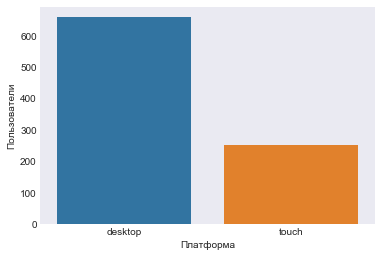

In [23]:
graf(daily_users_device_df['device'],
     daily_users_device_df['user_count'],
     'Платформа',
     'Пользователи')

Количество ежедневных пользователей по источникам трафика:

In [24]:
daily_users_source = visits.groupby(['source_id', 'day']).agg({'uid':'nunique'}).reset_index()
daily_users_source_df = daily_users_source.groupby('source_id')['uid'].mean().reset_index()
daily_users_source_df.columns = ['source_id', 'user_count']
daily_users_source_df = daily_users_source_df
daily_users_source_df

,source_id,user_count
0,1,80.524725
1,2,120.628099
2,3,232.790634
3,4,275.385675
4,5,175.603306
5,6,1.000000
6,7,1.058824
7,9,36.074380
8,10,26.022039


Заметно, как отличается количество посетителей в зависимости от канала, через который они привлекаются. Наибольшее количество пользователей пришло через каналы с номерами 3, 4 и 5. Наименьшее — через 6-й и 7-й.

Подготовим DF для построения графика. Удалим каналы 6 и 7 ввиду незначительности из вклада, ведь они сделают график менее удобно читаемыми.

In [25]:
daily_users_source_df_clean = daily_users_source_df.drop([5,6])
daily_users_source_df_clean

,source_id,user_count
0,1,80.524725
1,2,120.628099
2,3,232.790634
3,4,275.385675
4,5,175.603306
7,9,36.074380
8,10,26.022039


Зададим функцию построения pie-chart.

In [26]:
def pie(x, labels):
    plt.figure(figsize=(8,8))
    plt.pie(x, labels=labels, autopct='%1.1f%%')
    return plt.show()

Отметим, что на долю 4 канала приходится 29% всех посещений, на долю 3 — почти 25%, на долю 5 — 18.5%. В сумме эти три канала отвечают за 70% всего трафика.

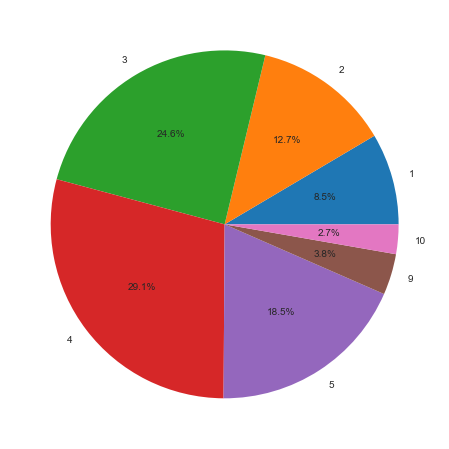

In [27]:
pie(daily_users_source_df_clean['user_count'], labels=daily_users_source_df_clean['source_id'])

---

Оценим количество еженедельных пользователей.

In [28]:
wau = visits.groupby(['year', 'week']).agg({'uid':'nunique'}).mean()
print('Количество еженедельных пользователей:', int(wau))

Количество еженедельных пользователей: 5716


Сделаем то же в разрезе по платформам.

In [29]:
weekly_users_device = visits.groupby(['device', 'week']).agg({'uid':'nunique'})
weekly_users_device_df = weekly_users_device.groupby('device')['uid'].mean().reset_index()
weekly_users_device_df.columns = ['device', 'user_count']
weekly_users_device_df

,device,user_count
0,desktop,4208.038462
1,touch,1666.038462


In [30]:
weekly_users_device_df['pct'] = ((weekly_users_device_df['user_count'] / weekly_users_device_df['user_count'].sum()) * 100).round(1)
weekly_users_device_df

,device,user_count,pct
0,desktop,4208.038462,71.6
1,touch,1666.038462,28.4


Картина похожа на то, что мы уже видели в разрезе по дням с чуть большей долей мобильного трафика. Впрочем, на долю десктоп-пользователей все равно приходится более 70% всех посещений.

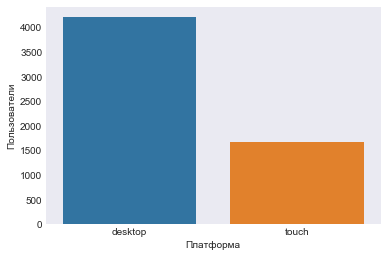

In [31]:
graf(weekly_users_device_df['device'],
     weekly_users_device_df['user_count'],
     'Платформа',
     'Пользователи')

Посмотрим на распределение трафика по источникам его привлечения.

In [32]:
weekly_users_source = visits.groupby(['source_id', 'week']).agg({'uid':'nunique'})
weekly_users_source_df = weekly_users_source.groupby('source_id')['uid'].mean().reset_index()
weekly_users_source_df.columns = ['source_id', 'user_count']
weekly_users_source_df

,source_id,user_count
0,1,472.057692
1,2,728.711538
2,3,1595.596154
3,4,1863.961538
4,5,1189.788462
5,6,1.000000
6,7,1.333333
7,9,243.057692
8,10,169.711538


In [33]:
weekly_users_source_df = weekly_users_source_df.drop([5,6])
weekly_users_source_df

,source_id,user_count
0,1,472.057692
1,2,728.711538
2,3,1595.596154
3,4,1863.961538
4,5,1189.788462
7,9,243.057692
8,10,169.711538


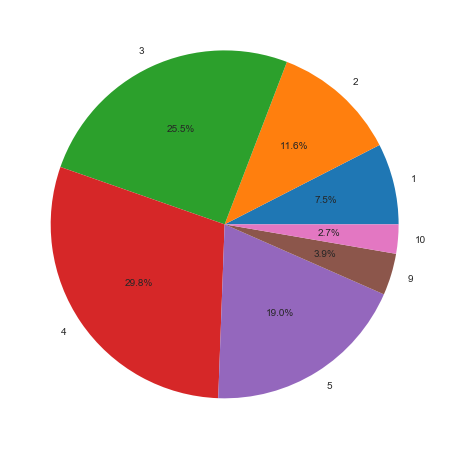

In [34]:
pie(weekly_users_source_df['user_count'], labels=weekly_users_source_df['source_id'])

3-й (25.5% трафика), 4 (29.8%) и 5 (19%) источники трафика занимают примерно те же доли, что и в случае с ежедневными пользователями. На их долю приходится почти 3/4 еженедельного трафика.

---

In [35]:
mau = visits.groupby(['year', 'month']).agg({'uid':'nunique'}).mean()
print('Количество ежемесячных пользователей:', int(mau))

Количество ежемесячных пользователей: 23228


В разбивке по устройствам.

In [36]:
monthly_users_device = visits.groupby(['device', 'month']).agg({'uid':'nunique'})
monthly_users_device_df = monthly_users_device.groupby('device')['uid'].mean().reset_index()
monthly_users_device_df.columns = ['device', 'user_count']
monthly_users_device_df

,device,user_count
0,desktop,16724.500000
1,touch,6825.166667


In [37]:
monthly_users_device_df['pct'] = ((monthly_users_device_df['user_count'] / monthly_users_device_df['user_count'].sum()) * 100).round(1)
monthly_users_device_df

,device,user_count,pct
0,desktop,16724.500000,71.0
1,touch,6825.166667,29.0


Та же картина, что и с разбивкой по неделям.

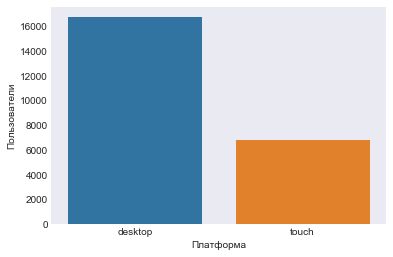

In [38]:
graf(monthly_users_device_df['device'],
     monthly_users_device_df['user_count'],
     'Платформа',
     'Пользователи')

In [39]:
monthly_users_source = visits.groupby(['source_id', 'month']).agg({'uid':'nunique'})
monthly_users_source_df = monthly_users_source.groupby('source_id')['uid'].mean().reset_index()
monthly_users_source_df.columns = ['source_id', 'user_count']
monthly_users_source_df

,source_id,user_count
0,1,1818.583333
1,2,2750.000000
2,3,6757.333333
3,4,7764.416667
4,5,5017.500000
5,6,1.000000
6,7,2.833333
7,9,986.250000
8,10,706.833333


In [40]:
monthly_users_source_df = monthly_users_source_df.drop([5,6])
monthly_users_source_df

,source_id,user_count
0,1,1818.583333
1,2,2750.000000
2,3,6757.333333
3,4,7764.416667
4,5,5017.500000
7,9,986.250000
8,10,706.833333


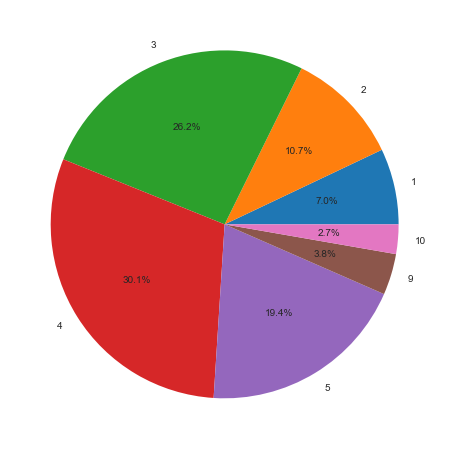

In [41]:
pie(monthly_users_source_df['user_count'], labels=monthly_users_source_df['source_id'])

И снова та же картина, что и с разбивкой по неделям, что неудивительно, ведь недельные  и ежемесячные пользователи — это агрегированная метрика от пользователей ежедневных. Незначительные различия возможны, но ничего такого, что кардинально меняло бы всю картину.

Посмотрим на динамику посещений по источникам трафика по месяцам. Подготовим таблицу:

In [42]:
visits_month = visits.copy()
visits_month['y_month'] = visits_month['start_ts'].dt.to_period('M')
visits_month = visits_month.groupby(['source_id', 'y_month'])['uid'].nunique().unstack().T.fillna(0)
visits_month

source_id,1,2,3,4,5,6,7,9,10
y_month,,,,,,,,,
2017-06,972.0,1529.0,4225.0,3634.0,2903.0,0.0,2.0,751.0,426.0
2017-07,1047.0,1775.0,4067.0,4114.0,3726.0,1.0,2.0,562.0,316.0
2017-08,794.0,1272.0,3414.0,3128.0,3145.0,1.0,1.0,612.0,244.0
2017-09,1393.0,2127.0,5824.0,5374.0,4932.0,1.0,3.0,781.0,502.0
2017-10,2170.0,3343.0,8531.0,9512.0,7525.0,0.0,5.0,1040.0,926.0
2017-11,2790.0,4190.0,10185.0,11225.0,6504.0,1.0,1.0,1486.0,888.0
2017-12,2735.0,3702.0,9192.0,11786.0,6221.0,1.0,9.0,1234.0,621.0
2018-01,2142.0,3166.0,8529.0,10247.0,5738.0,1.0,4.0,1058.0,925.0
2018-02,2121.0,3158.0,8683.0,9756.0,5951.0,0.0,3.0,1036.0,1088.0


Построим линейный график.

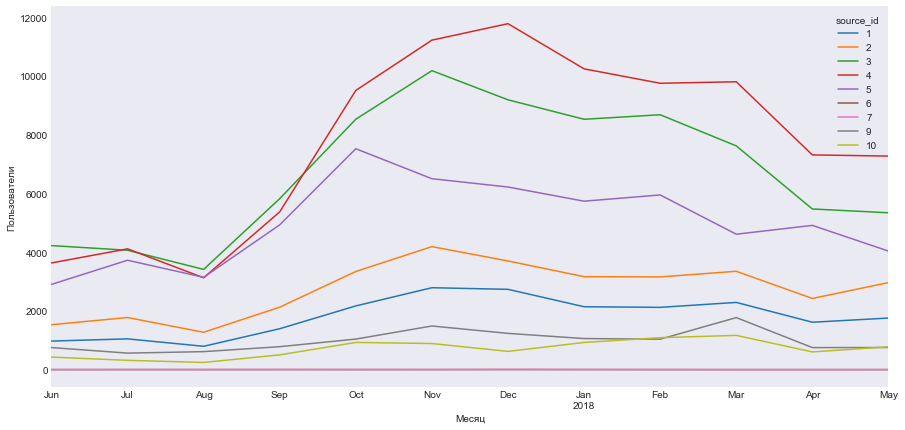

In [43]:
fig, ax = plt.subplots(figsize=(15,7))
visits_month.plot(ax=ax)
plt.xlabel("Месяц")
plt.ylabel("Пользователи")
plt.show()

Какие выводы можно сделать по графику? Общий маркетинговый бюджет сначала рост, потом падал.  При этом соотношение различных видов источников трафика менялось со временам, а вот приоритет каждого из источников (его место в рейтинге) практически не менялся. Все время наблюдения источники 3, 4 и 5 входили в топ-3 по количеству привлеченных пользователей. По состоянию на май 2018 года отрыв между ними и источником 2 сократился, но все еще остается внушительным. Источники под номерами 6 и 7 практически не приносят трафика на протяжении всего времени.

#### *Сколько сессий в день?*

Мы уже выяснили, какое количество уникальных пользователей посещает сайт каждый день / неделю / месяц. теперь посмотрим на количество посещений (ведь каждый пользователь может посетить сайт неограниченное количество раз).

In [44]:
visits['ses_duration'] = (visits['end_ts'] - visits['start_ts']).astype('timedelta64[s]')
ses_per_day = visits.groupby('day').agg({'ses_duration' : 'count'}).reset_index()
ses_per_day.columns = ['day', 'ses_count']
print('Сессий в день:', int(ses_per_day.mean()))

Сессий в день: 984


In [45]:
ses_per_day_device = visits.groupby(['device', 'day']).agg({'ses_duration' : 'count'})
ses_per_day_device_df = ses_per_day_device.groupby('device')['ses_duration'].mean().reset_index()
ses_per_day_device_df.columns = ['device', 'ses_count']
ses_per_day_device_df

,device,ses_count
0,desktop,719.541209
1,touch,266.168044


In [46]:
ses_per_day_device_df['pct'] = ((ses_per_day_device_df['ses_count'] / ses_per_day_device_df['ses_count'].sum()) * 100).round(1)
ses_per_day_device_df

,device,ses_count,pct
0,desktop,719.541209,73.0
1,touch,266.168044,27.0


Распределение такое же, как и в случае с уникальными пользователями. 73% для десктоп-трафика и 27% для мобильного.

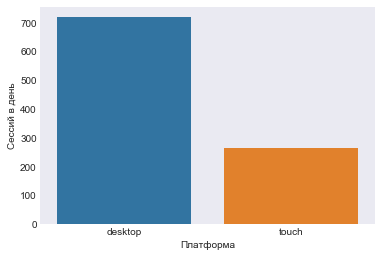

In [47]:
graf(ses_per_day_device_df['device'],
     ses_per_day_device_df['ses_count'],
     'Платформа',
     'Сессий в день')

Как выглядит распределение сессий по источникам трафика? Уже известным образом подготавливаем DF и строим график.

In [48]:
ses_per_day_source = visits.groupby(['source_id', 'day']).agg({'ses_duration' : 'count'})
ses_per_day_source_df = ses_per_day_source.groupby('source_id')['ses_duration'].mean().reset_index()
ses_per_day_source_df.columns = ['source_id', 'ses_count']
ses_per_day_source_df

,source_id,ses_count
0,1,93.250000
1,2,130.779614
2,3,235.393939
3,4,280.035813
4,5,183.776860
5,6,1.000000
6,7,1.058824
7,9,36.520661
8,10,27.561983


In [49]:
ses_per_day_source_df_clean = ses_per_day_source_df.drop([5,6])
ses_per_day_source_df_clean

,source_id,ses_count
0,1,93.250000
1,2,130.779614
2,3,235.393939
3,4,280.035813
4,5,183.776860
7,9,36.520661
8,10,27.561983


В целом так же, как и для уникальных пользователей. Соотношение маркетинговых каналов приблизительно такое же.

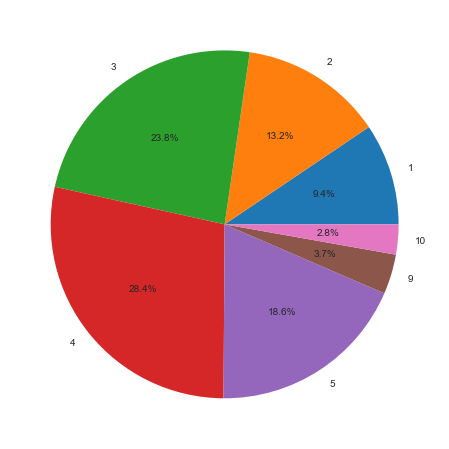

In [50]:
pie(ses_per_day_source_df_clean['ses_count'], ses_per_day_source_df_clean['source_id'])

Построим график распределения посещений по месяцам и источникам трафика. 

In [51]:
ses_month = visits.copy()
ses_month['y_month'] = ses_month['start_ts'].dt.to_period('M')
ses_month = ses_month.groupby(['source_id', 'y_month'])['uid'].count().unstack().T.fillna(0)
ses_month

source_id,1,2,3,4,5,6,7,9,10
y_month,,,,,,,,,
2017-06,1532.0,2178.0,4428.0,3899.0,3108.0,0.0,2.0,821.0,475.0
2017-07,1627.0,2478.0,4265.0,4390.0,4039.0,1.0,2.0,620.0,341.0
2017-08,1248.0,1858.0,3573.0,3291.0,3395.0,1.0,1.0,683.0,268.0
2017-09,2072.0,3011.0,6086.0,5782.0,5471.0,1.0,3.0,874.0,539.0
2017-10,3263.0,4621.0,8989.0,10465.0,8283.0,0.0,5.0,1162.0,1001.0
2017-11,4494.0,6065.0,10788.0,12567.0,7234.0,1.0,1.0,1665.0,1053.0
2017-12,4373.0,5619.0,9705.0,13131.0,6921.0,1.0,9.0,1421.0,718.0
2018-01,3260.0,4683.0,8942.0,11205.0,6342.0,1.0,4.0,1168.0,1263.0
2018-02,3407.0,4670.0,9153.0,10643.0,6703.0,0.0,5.0,1122.0,1401.0


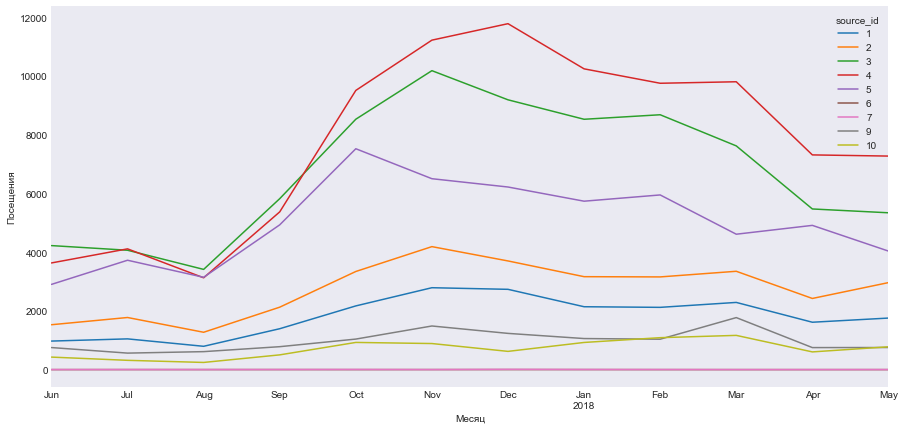

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
visits_month.plot(ax=ax)
plt.xlabel("Месяц")
plt.ylabel("Посещения")
plt.show()

Можно с уверенностью утверждать, что соотношение трафика по каналами продвижения и общий объем привлеченного трафика соответствуют аналогичной информации на графике с пользователями. Это говорит о том, что число сессий, которые приходятся на одного пользователя, практически постоянно и не слишком отличается в зависимости от канала, через который пользователь пришел на сайт.

#### *Сколько длится одна сессия?*

Взглянем на гистограмму длительности сессий. Преобладают короткие сессии. Продолжительные, хоть и присутствуют в достаточном количестве, все же не отражают общей картины. Параметр "rug" в данном случае позволяет визуально оценить наличие и и количество сессий определенной длины.

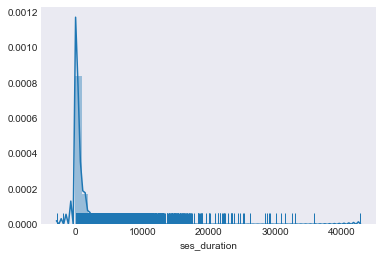

In [53]:
sns.distplot(visits['ses_duration'], bins=50, rug=True)

Ввиду того, что на графике — распределение с ярко выраженной положительной асимметрией, а большинство значений сосредоточены около 0, имеет смысл найти среднее значение по моде, а не медиане или среднему арифметическому.

In [54]:
session_dur_mode = int(visits['ses_duration'].mode())
print('Средняя продолжительность сессии: {} сек.'.format(session_dur_mode))

Средняя продолжительность сессии: 60 сек.


#### *Как часто люди возвращаются?*

Существует несколько способов для того, чтобы оценить частоту повторных посещений сайта пользователями.

Способ 1. Посмотреть, какое количество раз каждый пользователь посетил сайт в рамках одного месяца и найти среднее для всех пользователей.

In [55]:
ses_per_user = visits.groupby(['year', 'month']).agg({'uid':['count', 'nunique']}).reset_index()
ses_per_user.columns = ['year', 'month', 'sessions', 'unique_users']
ses_per_user

,year,month,sessions,unique_users
0,2017,6,16443,13259
1,2017,7,17763,14183
2,2017,8,14318,11631
3,2017,9,23839,18975
4,2017,10,37789,29692
5,2017,11,43868,32797
6,2017,12,41898,31557
7,2018,1,36868,28716
8,2018,2,37104,28749
9,2018,3,35576,27473


In [56]:
ses_per_user['ses_per_user'] = ses_per_user['sessions'] / ses_per_user['unique_users']
round(ses_per_user['ses_per_user'].mean(), 2)

1.28

Получается, что в среднем на пользователя приходится 1.28 посещений сайта в месяц. Такой способ, однако, не учитывает посещения, совершенные пользователями за все время пользования сервисом. Отсюда и другой способ.

Способ 2. Посмотреть, какое количество посещений приходится на одного пользователя за все время.

In [57]:
unique_user = visits['uid'].nunique()
user_count = visits['uid'].count()

round((user_count/unique_user), 2)

1.57

1.58 посещений на пользователя вместо 1.28 как в способе 1. Это говорит о том, что и после первого месяца некоторые пользователи продолжают использовать сервис. Данный способ, однако, не учитывает разницы в возрасте клиентов. Очевидно, данных о более старых клиентах накопилось больше. У них было больше времени повторно посетить сайт, чем у клиентов-новичков. Отсюда еще один способ.

Способ 3. Когортный анализ retention rate. Разобьем всех пользователей по когортам. Когорты формируем по месяцам. Событие-триггер — первое посещение сайта.

In [58]:
visits.head()

,uid,start_ts,end_ts,device,source_id,year,day,week,month,ses_duration
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,2017,2017-12-20,51,12,1080.0
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,2018,2018-02-19,8,2,1680.0
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,touch,5,2017,2017-07-01,26,7,0.0
3,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,2018,2018-05-20,20,5,1440.0
4,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,desktop,3,2017,2017-12-27,52,12,0.0


In [59]:
first_date = visits.groupby('uid')['start_ts'].min().reset_index()
first_date.columns = ['uid', 'first_date']
retention_df = pd.merge(first_date, visits, on='uid')
retention_df.head()

,uid,first_date,start_ts,end_ts,device,source_id,year,day,week,month,ses_duration
0,11863502262781,2018-03-01 17:27:00,2018-03-01 17:27:00,2018-03-01 17:33:00,touch,3,2018,2018-03-01,9,3,360.0
1,49537067089222,2018-02-06 15:55:00,2018-02-06 15:55:00,2018-02-06 15:57:00,touch,2,2018,2018-02-06,6,2,120.0
2,297729379853735,2017-06-07 18:47:00,2017-06-07 18:47:00,2017-06-07 18:48:00,desktop,3,2017,2017-06-07,23,6,60.0
3,313578113262317,2017-09-18 22:49:00,2018-03-11 17:23:00,2018-03-11 17:29:00,desktop,2,2018,2018-03-11,10,3,360.0
4,313578113262317,2017-09-18 22:49:00,2017-09-18 22:49:00,2017-09-18 23:07:00,desktop,2,2017,2017-09-18,38,9,1080.0


Рассчитаем когороты.

In [60]:
retention_df['first_month'] = retention_df['first_date'].astype('datetime64[M]')
retention_df['month'] = retention_df['start_ts'].astype('datetime64[M]')
retention_df['cohort_lifetime'] = (retention_df['month'] - retention_df['first_month']) / np.timedelta64(1,'M')
retention_df['cohort_lifetime'] = retention_df['cohort_lifetime'].round().astype('int')
retention_df.head()

,uid,first_date,start_ts,end_ts,device,source_id,year,day,week,month,ses_duration,first_month,cohort_lifetime
0,11863502262781,2018-03-01 17:27:00,2018-03-01 17:27:00,2018-03-01 17:33:00,touch,3,2018,2018-03-01,9,2018-03-01,360.0,2018-03-01,0
1,49537067089222,2018-02-06 15:55:00,2018-02-06 15:55:00,2018-02-06 15:57:00,touch,2,2018,2018-02-06,6,2018-02-01,120.0,2018-02-01,0
2,297729379853735,2017-06-07 18:47:00,2017-06-07 18:47:00,2017-06-07 18:48:00,desktop,3,2017,2017-06-07,23,2017-06-01,60.0,2017-06-01,0
3,313578113262317,2017-09-18 22:49:00,2018-03-11 17:23:00,2018-03-11 17:29:00,desktop,2,2018,2018-03-11,10,2018-03-01,360.0,2017-09-01,6
4,313578113262317,2017-09-18 22:49:00,2017-09-18 22:49:00,2017-09-18 23:07:00,desktop,2,2017,2017-09-18,38,2017-09-01,1080.0,2017-09-01,0


In [61]:
cohorts = (retention_df
           .groupby(['first_month', 'cohort_lifetime'])
           .agg({'uid':'nunique'})
           .reset_index()
          )
cohorts.head()

,first_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [62]:
initial_user_count = cohorts[cohorts['cohort_lifetime']==0][['first_month', 'uid']]
initial_user_count.columns = ['first_month', 'user_count']
initial_user_count.head()

,first_month,user_count
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [63]:
cohorts = pd.merge(cohorts, initial_user_count, on='first_month')
cohorts.head()

,first_month,cohort_lifetime,uid,user_count
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [64]:
cohorts['first_month'] = cohorts['first_month'].dt.to_period('M')
cohorts.head()

,first_month,cohort_lifetime,uid,user_count
0,2017-06,0,13259,13259
1,2017-06,1,1043,13259
2,2017-06,2,713,13259
3,2017-06,3,814,13259
4,2017-06,4,909,13259


In [65]:
cohorts['retention'] = cohorts['uid'] / cohorts['user_count']
retention_pt = cohorts.pivot_table(index='first_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
retention_pt = retention_pt.drop(retention_pt.columns[0], axis=1)
retention_pt = retention_pt[:-1]
retention_pt

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,
2017-06,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получаем сводную таблицу с retention rate для каждой когорты. Наложим на нее график типа heat map для большей наглядности. Из таблицы удаляем первый столбец (в нем — информация о retention rate за первый месяц, у всех когорт он будет равен 100%) и последнюю строку (в ней только информация о первом месяце последней когорты, также 100%).

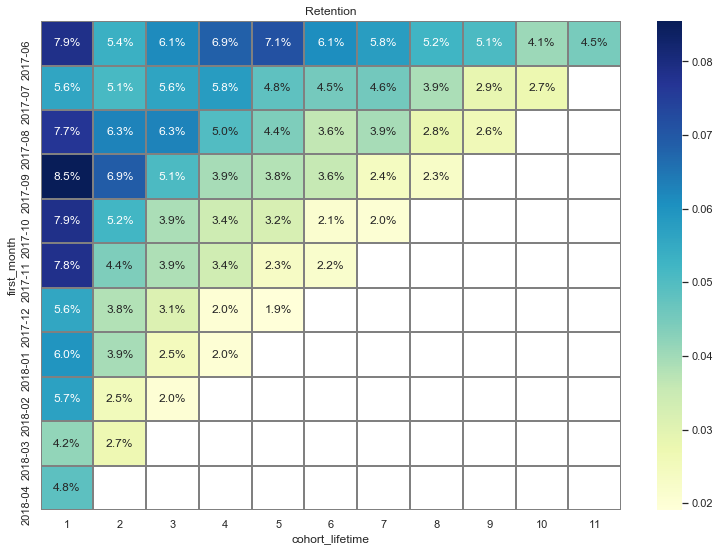

In [66]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention')
sns.heatmap(retention_pt, annot=True, fmt='.1%', cmap='YlGnBu', linewidths=1, linecolor='grey')
plt.show()

Заметно, насколько отличается retention rate по когортам. Самый высокий RR во второй месяц жизни когорты наблюдался в когортах 2017-09 (8.5%), 2017-06 (7.9%) и 2017-10 (7.9%). В более поздних когортах этот показатель снижается, а минимального значения достигает для когорты 2018-03 (4.2%).

RR в последующие месяцы также изменяется в зависимости от когорты. Так, для самой первой когорты RR за все 12 месяцев ни разу не опустился ниже 4%, а вот для последних когорт от достигает 2% уже через 4–5 месяцев. Разница может быть вызвана как новизной самого сервиса, так и выгодными условиями его использования для тех, кто присоединился раньше. Возможно, у этих людей есть постоянные скидки, которые делают Яндекс.Афишу предпочтительным сервисом приобретения билетов. Возможно, в то время проводилась более успешная и цепляющая маркетинговая кампания, результатом работы который стали клояльные клиенты (закупался более качественный трафик).

В целом заметно, что динамика по когортам от старших к младшим — негативная. Пользователей становится сложнее удерживать, она раньше "отваливаются".

### Продажи

На данном этапе исследования более детально рассмотрим данные о продажах через сервис Яндекс.Афиша.

Замечание: в столбце revenue таблицы orders содержится информация о выручке компании с данного заказа. По формату чисел сложно сказать, в каких единицах производятся расчеты. Не будем приводить значения в этом столбце к другому виду (например, умножая на 1000), так как и в столбце costs таблицы costs (информация о тратах) информация содержится в том же виде. Для выяснения прибыльности / убыточности бизнеса в целом и отдельных каналов этого вполне достаточно.

#### *Когда люди начинают покупать?*

Этот вопрос можно перефразировать. Сколько времени проходит между первым посещением сайта и совершением покупки. Получим время первой сессии и первой покупки для каждого пользователя.

In [67]:
first_session = visits.groupby('uid')['start_ts'].min().reset_index()
first_session.head()

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [68]:
first_buy = orders.groupby('uid')['buy_ts'].min().reset_index()
first_buy.head()

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Сопоставим и найдем разницу.

In [69]:
sales = pd.merge(first_buy, first_session, on='uid')
sales.head()

,uid,buy_ts,start_ts
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 11:22:00


In [70]:
sales['first_buy'] = (sales['buy_ts'] - sales['start_ts']).astype('timedelta64[D]')
sales.head()

,uid,buy_ts,start_ts,first_buy
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 11:22:00,-1.0


Посмотрим на распределение времени, которое проходит между первым посещением и первой покупкой.

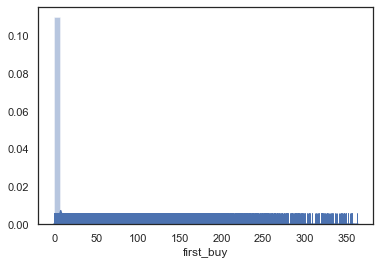

In [71]:
sns.distplot(sales['first_buy'], bins=50, rug=True)

Избавимся от выбросов, чтобы точнее оценить среднее значение.

In [72]:
sales_clean1 = sales[sales['first_buy'].between(sales['first_buy'].quantile(.05), sales['first_buy'].quantile(.95))]
sales_clean1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33832 entries, 0 to 36522
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   uid        33832 non-null  uint64        
 1   buy_ts     33832 non-null  datetime64[ns]
 2   start_ts   33832 non-null  datetime64[ns]
 3   first_buy  33832 non-null  float64       
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.3 MB


In [73]:
sales_clean1['first_buy'].mode()

0    0.0
dtype: float64

Мы выяснили, что большинство пользователей делают свой первый заказ в день первого посещения сайта. Выясним, сколько времени проходит между заходом на сайт и заказом.

In [74]:
sales['first_buy_min'] = (sales['buy_ts'] - sales['start_ts']).astype('timedelta64[m]')
sales.head()

,uid,buy_ts,start_ts,first_buy,first_buy_min
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106.0,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0.0,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0.0,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 11:22:00,-1.0,-68.0


In [75]:
sales_clean2 = sales[sales['first_buy_min'].between(sales['first_buy_min'].quantile(.05), sales['first_buy_min'].quantile(.95))]
sales_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33828 entries, 0 to 36522
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   uid            33828 non-null  uint64        
 1   buy_ts         33828 non-null  datetime64[ns]
 2   start_ts       33828 non-null  datetime64[ns]
 3   first_buy      33828 non-null  float64       
 4   first_buy_min  33828 non-null  float64       
dtypes: datetime64[ns](2), float64(2), uint64(1)
memory usage: 1.5 MB


Отобразим эту информацию визуально и рассчитаем моду, медиану и среднее арифметическое.

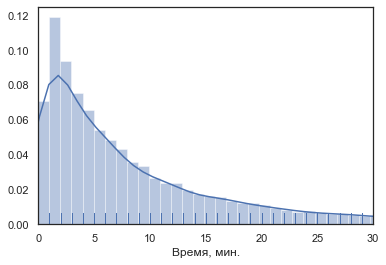

In [76]:
plt.xlim((0,30))
sns.distplot(sales_clean2[sales_clean2['first_buy_min'] < 100]['first_buy_min'], bins=100, rug=True)
plt.xlabel('Время, мин.')
plt.show()

In [77]:
sales_clean2['first_buy_min'].mode()

0    1.0
dtype: float64

In [78]:
sales_clean2['first_buy_min'].median()

15.0

In [79]:
int(sales_clean2['first_buy_min'].mean())

11310

Соотношение всех трех величин, так же как и график, говорят о ярко выраженном положительном смещении. Учитывая тип распределения, средним будем считать моду, то есть значение, равное 1 минуте.

#### *Сколько раз покупают за период?*

Используем когортный анализ.

In [80]:
orders.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01 00:10:00,17.00
1,11627257723692907447,2017-06-01 00:25:00,0.55
2,17903680561304213844,2017-06-01 00:27:00,0.37
3,16109239769442553005,2017-06-01 00:29:00,0.55
4,14200605875248379450,2017-06-01 07:58:00,0.37


In [81]:
first_deal = orders.groupby('uid')['buy_ts'].min().reset_index()
first_deal.columns = ['uid', 'first_buy']
first_deal.head()

,uid,first_buy
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [82]:
freq_df = pd.merge(first_deal, orders, on='uid')
freq_df.head()

,uid,first_buy,buy_ts,revenue
0,313578113262317,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 18:33:00,73.33
4,2464366381792757,2018-01-28 15:54:00,2018-01-28 15:54:00,2.44


In [83]:
freq_df['first_buy'] = freq_df['first_buy'].astype('datetime64[M]')
freq_df['buy_ts'] = freq_df['buy_ts'].astype('datetime64[M]')
freq_df['cohort_lifetime'] = (freq_df['buy_ts'] - freq_df['first_buy']) / np.timedelta64(1,'M')
freq_df['cohort_lifetime'] = freq_df['cohort_lifetime'].round().astype('int')
freq_df.head()

,uid,first_buy,buy_ts,revenue,cohort_lifetime
0,313578113262317,2018-01-01,2018-01-01,0.55,0
1,1575281904278712,2017-06-01,2017-06-01,1.22,0
2,1575281904278712,2017-06-01,2017-06-01,1.83,0
3,2429014661409475,2017-10-01,2017-10-01,73.33,0
4,2464366381792757,2018-01-01,2018-01-01,2.44,0


In [84]:
cohorts_fr = (freq_df
              .groupby(['first_buy', 'cohort_lifetime'])
              .agg({'uid':'nunique', 'buy_ts':'count'})
              .reset_index()
             )
cohorts_fr.columns = ['first_buy', 'cohort_lifetime', 'client_count', 'deal_count']
cohorts_fr.head()

,first_buy,cohort_lifetime,client_count,deal_count
0,2017-06-01,0,2023,2354
1,2017-06-01,1,61,177
2,2017-06-01,2,50,174
3,2017-06-01,3,54,226
4,2017-06-01,4,88,292


In [85]:
cohorts_fr['deal_per_client'] = cohorts_fr['deal_count'] / cohorts_fr['client_count']
cohorts_fr['first_buy'] = cohorts_fr['first_buy'].dt.to_period('M')
cohorts_fr.head()

,first_buy,cohort_lifetime,client_count,deal_count,deal_per_client
0,2017-06,0,2023,2354,1.163618
1,2017-06,1,61,177,2.901639
2,2017-06,2,50,174,3.480000
3,2017-06,3,54,226,4.185185
4,2017-06,4,88,292,3.318182


In [86]:
freq_pt = cohorts_fr.pivot_table(index='first_buy', columns='cohort_lifetime', values='deal_per_client', aggfunc='mean')
freq_pt

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy,,,,,,,,,,,,
2017-06,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Строим heat map на основе полученных данных.

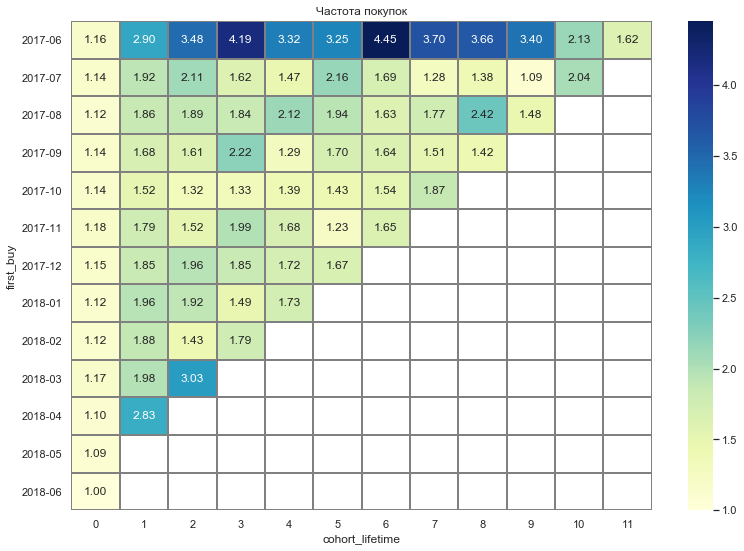

In [87]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Частота покупок')
sns.heatmap(freq_pt, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=1, linecolor='grey')
plt.show()

Поведение пользователей из первой когорты очень отличается от всех остальных. Даже по прошествии нескольких месяцев они продолжают пользоваться сервисом более активно, чем молодые когорты. Это также может быть связано с показателем retention, который у первой когорты был заметно выше, чем у остальных.

Можно заметить, что показатель, в отличие от RR, значительно выше в месяцы, следующие за первым. С чем это может быть связано? Скорее всего, дело вот в чем: в первый месяц сервисом пользуются многие люди, которые искали билеты на конкретное событие и, купив их, больше не собираются пользоваться сервисом. Такие люди совершают единственную покупку в свой первый месяц и больше на платформе не появляются. Во всяком случае, какое-то время. Те же, кто остаются (а это порядка 4% после первого месяца), начинают пользоваться сервисом на регулярной основе, часто посещая те или иные мероприятия, отсюда и более высокая частота покупок. Т. е. можно говорить об отдельной категории пользователей, для которых покупка билетов на мероприятия — часть повседневной жизни. Они, несомненно, будут отличаться по поведению от остальных пользователей, которых можно отнести к ситуационным покупателям.

#### *Какой средний чек?*

Для того, чтобы найти средний чек, сначала избавимся от выбросов. Удостоверимся в том, что удалено не слишком большое количество наблюдений.

In [88]:
orders_clean = (
                        orders[orders['revenue']
                       .between(orders['revenue'].quantile(.01),
                        orders['revenue'].quantile(.99))]
)
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49640 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   uid      49640 non-null  uint64        
 1   buy_ts   49640 non-null  datetime64[ns]
 2   revenue  49640 non-null  float64       
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


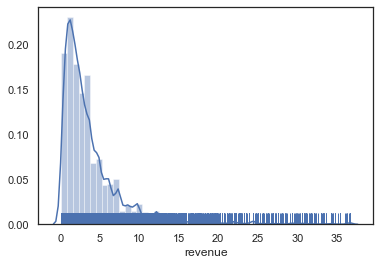

In [89]:
sns.distplot(orders_clean['revenue'], bins=50, rug=True)

Заметно, насколько отличается распределение величины среднего чека от, например, распределения времени сессии. Результаты куда более однородные. Впрочем, и здесь большинство значений сконцентрированы в диапазоне от 0 до 5. Вычислим средний чек тремя разными способами.

In [90]:
orders_clean['revenue'].mode()

0    1.83
dtype: float64

In [91]:
orders_clean['revenue'].median()

2.44

In [92]:
orders_clean['revenue'].mean()

4.023668815471407

Видим, что разница между модой, медианой и средним арифметическим в данном случае гораздо ниже, чем в случае со средним временем между заходом на сайт и покупкой. Остановимся на моде, примем значение среднего чека равным 1.83.

#### *Сколько денег приносят? (LTV)*

LTV также удобно рассчитать с применением когортного анализа.

Замечание: для расчета LTV используется понятие маржинальности, то есть того коэффициента, на который необходимо умножить выручку для получения валовой прибыли. В случае онлайн-сервиса владелец бизнеса не несет практически никаких переменных издержек. Поэтому маржинальность в целях расчетов будем считать равной 1.

In [93]:
orders.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01 00:10:00,17.00
1,11627257723692907447,2017-06-01 00:25:00,0.55
2,17903680561304213844,2017-06-01 00:27:00,0.37
3,16109239769442553005,2017-06-01 00:29:00,0.55
4,14200605875248379450,2017-06-01 07:58:00,0.37


In [94]:
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'first_buy']
first_order['first_buy'] = first_order['first_buy'].astype('datetime64[M]')
first_order.head()

,uid,first_buy
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [95]:
cohort_clients = first_order.groupby('first_buy')['uid'].nunique().reset_index()
cohort_clients.columns = ['first_buy', 'user_count']
cohort_clients.head()

,first_buy,user_count
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [96]:
order_month = orders
order_month['buy_ts'] = order_month['buy_ts'].astype('datetime64[M]')
order_month.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01,17.00
1,11627257723692907447,2017-06-01,0.55
2,17903680561304213844,2017-06-01,0.37
3,16109239769442553005,2017-06-01,0.55
4,14200605875248379450,2017-06-01,0.37


In [97]:
ltv_df = pd.merge(first_order, orders, on='uid')
ltv_df.head()

,uid,first_buy,buy_ts,revenue
0,313578113262317,2018-01-01,2018-01-01,0.55
1,1575281904278712,2017-06-01,2017-06-01,1.22
2,1575281904278712,2017-06-01,2017-06-01,1.83
3,2429014661409475,2017-10-01,2017-10-01,73.33
4,2464366381792757,2018-01-01,2018-01-01,2.44


In [98]:
cohorts = ltv_df.groupby(['first_buy', 'buy_ts']).agg({'revenue':'sum'}).reset_index()
cohorts.head()

,first_buy,buy_ts,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [99]:
ltv = pd.merge(cohorts, cohort_clients, on='first_buy')
ltv.head()

,first_buy,buy_ts,revenue,user_count
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


In [100]:
ltv['cohort_lifetime'] = (ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1, 'M')
ltv['cohort_lifetime'] = ltv['cohort_lifetime'].round().astype('int')
ltv.head()

,first_buy,buy_ts,revenue,user_count,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,0
1,2017-06-01,2017-07-01,981.82,2023,1
2,2017-06-01,2017-08-01,885.34,2023,2
3,2017-06-01,2017-09-01,1931.30,2023,3
4,2017-06-01,2017-10-01,2068.58,2023,4


In [101]:
ltv['ltv'] = ltv['revenue'] / ltv['user_count']
ltv_pt = ltv.pivot_table(index='first_buy', columns='cohort_lifetime', values='ltv', aggfunc='mean')
ltv_pt

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


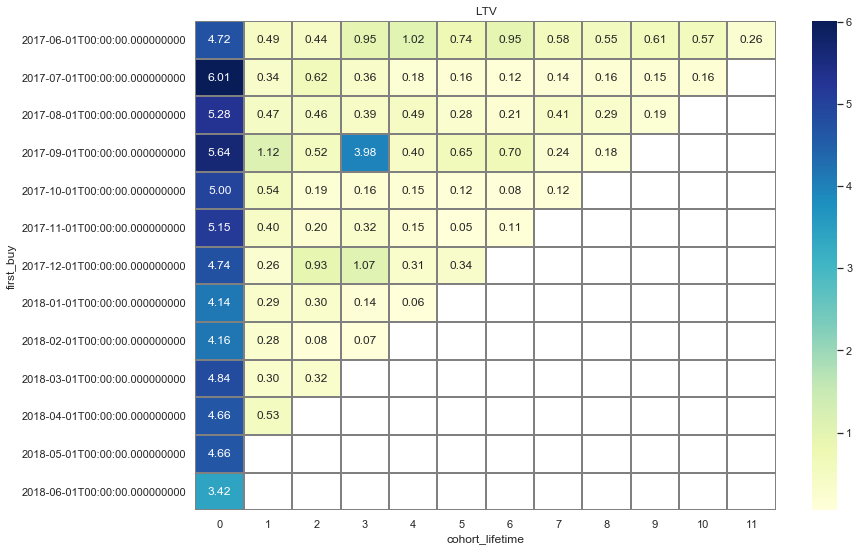

In [102]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(ltv_pt, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=1, linecolor='grey')
plt.show()

Видно, что большую часть прибыли когорты приносят в первый месяц своего существования, начиная со второго она заметно снижается. В данном случае первая когорта также качественно отличается от всех последующих, демонстрируя гораздо более высокую прибыль в месяцы, следующие за первым.

В глаза бросается аномально высокий уровень прибыли, продемонстрированный покупателями из 4-й когорты в 4-й месяц своей "жизни". Возможно, отделу маркетинга стоит обратить внимание на этот всплеск и выяснить, с чем он был связан. Возможно, был опробован некоторый альтернативный способ продвижения. Возможно, в это время проходило какое-то мероприятие, заинтересовавшее покупателей из этой когорты. Поняв причины всплеска, можно будет попытаться стимулировать подобное поведение покупателей в будущем (или хотя бы убедиться в том, что это невозможно).

Как найти LTV? Данные заполнены не целиком, а информация за все 12 месяцев имеется только для первой когорты. Как в таком случае рассчитать LTV для клиентов сервиса? Посчитаем сумму средних каждого столбца. Так мы учтем все имеющиеся данные, включив как более, так и менее результативные когорты, а не только первую. В то же время, это поможет избежать проблем с пропусками.

In [103]:
ltv_final = ltv_pt.mean(skipna=True).sum()
ltv_final.round(2)

9.06

LTV клиента приблизительно равен 9 денежным единицам.

### Маркетинг

#### *Сколько денег потратили? Всего / на каждый источник / по времени.*

In [104]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Общие затраты найдем, просто просуммировав данные в столбце costs таблицы costs.

In [105]:
total_costs = costs['costs'].sum().round().astype('int')
total_costs

329132

Общие затраты на маркетинг равны 329 132 денежных единиц. Сколько стоит привлечение одного пользователя?

In [106]:
cac = total_costs / orders['uid'].nunique()
cac.round(2)

9.01

Привлечение одного пользователя обходится примерно во столько же, сколько составляет LTV. Это говорит о том, что существующие расходы едва покрываются даже не текущей, а ожидаемой прибылью от всех приведенных на платформу клиентов.

Посмотрим на распределение затрат по источникам трафика.

In [107]:
cost_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
cost_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Первые три места по бюджету занимают каналы продвижения по номерами 3, 4 и 5. При этом канал №3 лидирует с большим отрывом. Из 329 132 общего бюджета на него приходится 141 321. Мы помним, что на эти каналы приходится большая часть поступающего на сайт трафика и, как следует, покупателей. Источники трафика 6 и 7 вовсе не попали в эту таблицу. Видимо, по причине того, что на них не выделяется бюджет, а трафик из них может считаться органическим. Отсюда и крайне низкое количество пользователей, пришедших через них на сайт.

Вот как распределение затрат по источникам выглядит на графике:

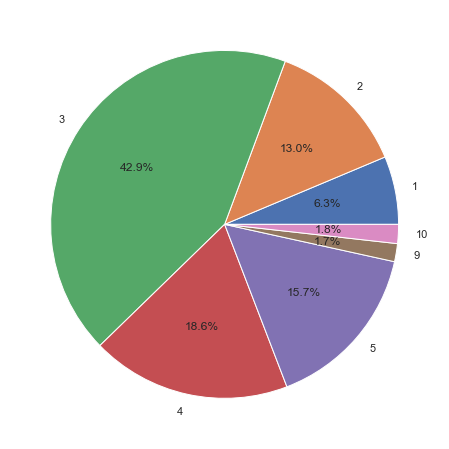

In [108]:
pie(cost_by_source['costs'], cost_by_source['source_id'])

Бюджет 3-го канала составляет более 40% общего рекламного бюджета. 4-й и 5-й каналы занимают второе и третье места соответственно. На оставшиеся 4 канала в сумме приходится меньше 23% рекламного бюджета.

Изменение общих затрат по времени:

In [109]:
costs['month_year'] = costs['dt'].astype('datetime64[M]')
cost_by_time = costs.groupby('month_year')['costs'].sum().reset_index()
cost_by_time

,month_year,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


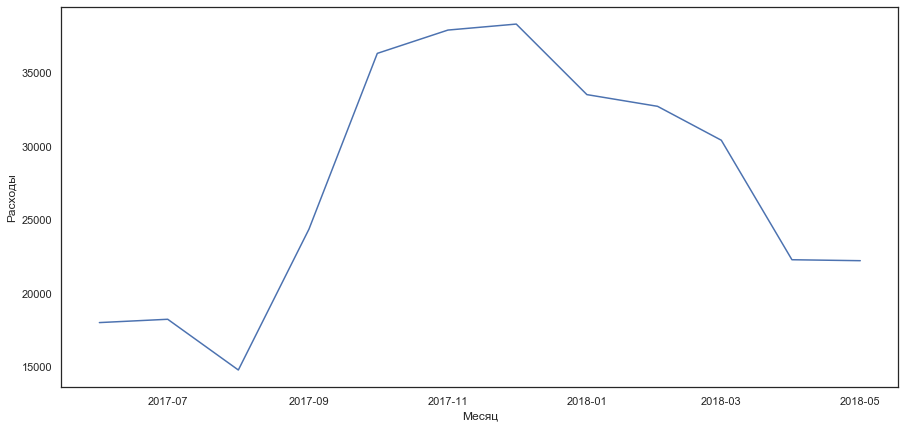

In [110]:
plt.figure(figsize=(15,7))
sns.lineplot(x='month_year', y='costs', data=cost_by_time)
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

Рекламный бюджет рос в первой половине рассматриваемого периода и падал во второй. С чем может быть связана такая динамика, сказать сложно. на основании имеющихся данных получить ответ на этот вопрос невозможно. За ответом необходимо обратиться к бизнесу.

Посмотрим на распределение бюджета по источникам трафика по месяцам.

In [111]:
traffic_spend = costs.copy()
traffic_spend['dt'] = traffic_spend['dt'].astype('datetime64[M]')
traffic_spend_df = traffic_spend.pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')
traffic_spend_df

source_id,1,2,3,4,5,9,10
dt,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


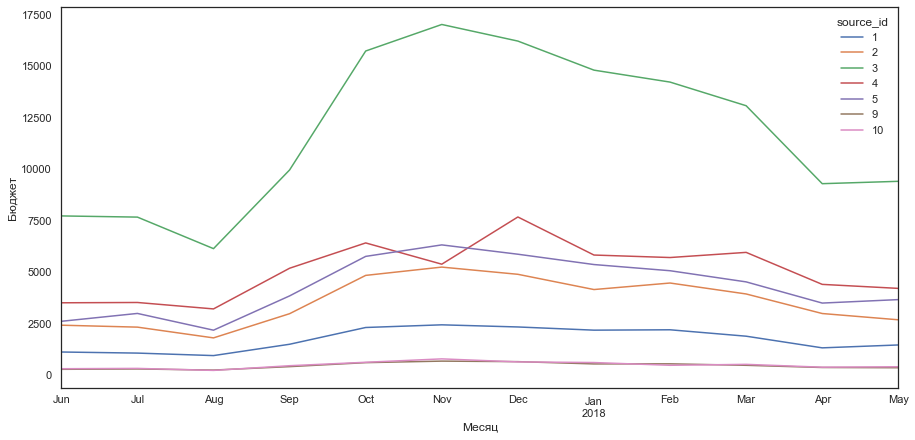

In [112]:
fig, ax = plt.subplots(figsize=(15,7))
traffic_spend_df.plot(ax=ax)
plt.xlabel("Месяц")
plt.ylabel("Бюджет")
plt.show()

Этот график серьезно отличается от того, который мы видели в случае распределения источников трафика по сессиям / посетителям. Очевидно, конверсия источников не одинакова, а на единицу денежных средств, потраченных в разных каналах, приходится разное количество привлеченных клиентов. Каналы 3, 4 и 5 по-прежнему занимают три первых места на протяжении всего срока наблюдения. При этом на источник №3 тратится непропорционально много средств. Стоит выяснить, насколько окупаются подобные траты.

#### *Сколько стоило привлечение одного покупателя из каждого источника?*

Рассчитаем суммарный бюджет на каждый источник трафика за 12 месяцев.

In [113]:
cost_by_source = costs.groupby('source_id')['costs'].sum()
cost_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

И общее количество привлеченных клиентов по источнику трафика.

In [114]:
source_user_count = visits.groupby('source_id')['uid'].nunique()
source_user_count

source_id
1     18999
2     26245
3     74756
4     83525
5     56974
6         6
7        34
9      9264
10     8067
Name: uid, dtype: int64

In [115]:
user_cost = pd.merge(source_user_count, cost_by_source, on='source_id')
user_cost.columns = ['user_count', 'costs']
user_cost

,user_count,costs
source_id,,
1,18999,20833.27
2,26245,42806.04
3,74756,141321.63
4,83525,61073.60
5,56974,51757.10
9,9264,5517.49
10,8067,5822.49


In [116]:
user_cost['cost_per_user'] = user_cost['costs'] / user_cost['user_count']
user_cost

,user_count,costs,cost_per_user
source_id,,,
1,18999,20833.27,1.096546
2,26245,42806.04,1.631017
3,74756,141321.63,1.890439
4,83525,61073.60,0.731201
5,56974,51757.10,0.908434
9,9264,5517.49,0.595584
10,8067,5822.49,0.721766


Заметно, насколько отличается стоимость привлечения одного клиента в зависимости от канала. Нельзя, однако, сказать, что более дешевые каналы привлечения являются предпочтительным, так как, возможно, клиенты из разных каналов будут вести себя по разному и тратить на сайте разное количество денег, тем самым окупая затраты на свое привлечение.

Дополним информацией о revenue per user.

In [117]:
orders.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01,17.00
1,11627257723692907447,2017-06-01,0.55
2,17903680561304213844,2017-06-01,0.37
3,16109239769442553005,2017-06-01,0.55
4,14200605875248379450,2017-06-01,0.37


In [118]:
rev_per_user = orders.groupby('uid')['revenue'].sum().reset_index()
rev_per_user.head()

,uid,revenue
0,313578113262317,0.55
1,1575281904278712,3.05
2,2429014661409475,73.33
3,2464366381792757,2.44
4,2551852515556206,10.99


Найдем первый источник трафика для каждого пользователя. Именно его и будем считать для пользователя основным.

In [119]:
first_source = visits.groupby('uid')['start_ts'].min().reset_index()
first_source.head()

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [120]:
user_info_df = pd.merge(rev_per_user, first_source, on='uid')
user_info_df.head()

,uid,revenue,start_ts
0,313578113262317,0.55,2017-09-18 22:49:00
1,1575281904278712,3.05,2017-06-03 10:13:00
2,2429014661409475,73.33,2017-10-11 17:14:00
3,2464366381792757,2.44,2018-01-27 20:10:00
4,2551852515556206,10.99,2017-11-24 11:22:00


In [121]:
first_source_df = pd.merge(user_info_df, visits[['uid', 'start_ts', 'source_id']], on=['uid', 'start_ts'], how='left')
first_source_df.head()

,uid,revenue,start_ts,source_id
0,313578113262317,0.55,2017-09-18 22:49:00,2
1,1575281904278712,3.05,2017-06-03 10:13:00,10
2,2429014661409475,73.33,2017-10-11 17:14:00,3
3,2464366381792757,2.44,2018-01-27 20:10:00,5
4,2551852515556206,10.99,2017-11-24 11:22:00,5


In [122]:
rev_per_source = first_source_df.groupby('source_id')['revenue'].sum().reset_index()
rev_per_source

,source_id,revenue
0,1,29876.00
1,2,46574.17
2,3,54391.15
3,4,56682.99
4,5,54407.71
5,7,1.22
6,9,5666.56
7,10,4457.40


In [123]:
cost_rev_df = pd.merge(user_cost, rev_per_source, on='source_id')
cost_rev_df['rev_per_user'] = cost_rev_df['revenue'] / cost_rev_df['user_count']
cost_rev_df = cost_rev_df[['source_id', 'user_count', 'costs', 'revenue', 'cost_per_user', 'rev_per_user']]
cost_rev_df['user_profit'] = cost_rev_df['rev_per_user'] - cost_rev_df['cost_per_user']
cost_rev_df = cost_rev_df.sort_values(by='user_profit', ascending=False)
cost_rev_df

,source_id,user_count,costs,revenue,cost_per_user,rev_per_user,user_profit
0,1,18999,20833.27,29876.00,1.096546,1.572504,0.475958
1,2,26245,42806.04,46574.17,1.631017,1.774592,0.143575
4,5,56974,51757.10,54407.71,0.908434,0.954957,0.046523
5,9,9264,5517.49,5666.56,0.595584,0.611675,0.016091
3,4,83525,61073.60,56682.99,0.731201,0.678635,-0.052566
6,10,8067,5822.49,4457.40,0.721766,0.552547,-0.169219
2,3,74756,141321.63,54391.15,1.890439,0.727582,-1.162856


В итоге получаем таблицу с соотношением цены привлечения и выручки по пользователям. По столбцу user_profit можно судить о прибыльности того или иного канала привлечения. В расчете на одного пользователя, самым выгодным является канал №1, на втором и третьем местах каналы 2 и 9 соответственно. А вот из топ-3 каналов по количеству привлеченных пользователей только 5-й продемонстрировал положительную прибыль на клиента. Канал 3 оказался самым убыточным, при этом на него тратится больше всего средств.

#### *Насколько окупились расходы? (ROI)*

In [124]:
total_cost = costs['costs'].sum()
total_revenue = orders['revenue'].sum()
roi = (total_revenue - total_cost) / total_cost
print('Общий ROI: {:.1%}'.format(roi))

Общий ROI: -23.4%


На данный момент, основываясь на уже имеющихся данных о выручки и расходах, компания терпит убытки. ROI составляет -23.4%. Однако ROI можно посчитать и по-другому. За выручку примем суммарный LTV всех пользователей, уже привлеченных на платформу. В данном случае мы допускаем, что расходы на маркетинг тратятся исключительно на привлечение новых клиентов, а не на реактивацию уже существующих.

In [125]:
roi_2 = ((orders['uid'].nunique() * ltv_final) - total_cost) / total_cost
print('Ожидаемый ROI: {:.1%}'.format(roi_2))

Ожидаемый ROI: 0.6%


Рассчитанный таким образом ROI составляет 0.6%, доходы едва покрывают расходы. Очевидно, что в этом виновата неэффективная маркетинговая стратегия.

ROI по источникам выглядит следующим образом:

In [126]:
roi_by_source = cost_rev_df.copy()
roi_by_source['roi'] = ((roi_by_source['revenue'] - roi_by_source['costs']) / roi_by_source['costs']) * 100
roi_by_source

,source_id,user_count,costs,revenue,cost_per_user,rev_per_user,user_profit,roi
0,1,18999,20833.27,29876.00,1.096546,1.572504,0.475958,43.405236
1,2,26245,42806.04,46574.17,1.631017,1.774592,0.143575,8.802800
4,5,56974,51757.10,54407.71,0.908434,0.954957,0.046523,5.121249
5,9,9264,5517.49,5666.56,0.595584,0.611675,0.016091,2.701772
3,4,83525,61073.60,56682.99,0.731201,0.678635,-0.052566,-7.189047
6,10,8067,5822.49,4457.40,0.721766,0.552547,-0.169219,-23.445124
2,3,74756,141321.63,54391.15,1.890439,0.727582,-1.162856,-61.512509


Источник №1 может похвастаться самым высоким ROI, почти 50%. В то же время доля этого источника в общем бюджете остается незначительной. Для трех оставшихся источников трафика с положительным ROI этот показатель не превышает 10%. У источников под номерами 3, 4 и 10 ROI отрицательный. В случае 3-го источника трафика достигает -61%.

### Вывод по шагу 2

В ходе проведения исследования удалось установить, что:
- Количество ежедневных пользователей равно 907.
- Количество еженедельных пользователей равно 5716.
- Количество ежемесячных пользователей равно 23228.

Почти 3/4 всех пользователей пользуются сервисом со стационарных ПК и только 1/4 с мобильных устройств. По части привлечения клиентов доминируют три источника трафика — под номерами 3, 4 и 5. Каналы 6 и 7 являются бесплатными, так как на них не расходуется бюджет. Объем привлеченного ими трафика остается крайне скромным на протяжении всего срока наблюдения.

Большинство клиентов совершают свою первую покупку в день первого посещения сайта. Между этими двумя событиями обычно проходит порядка одной минуты. Метрики LTV и CAC практически идентичны (каждый приблизительно равен 9 денежным единицам), что говорит об отсутствии прибыли. Действительно, на данный момент компания обладает отрицательным ROI.

## Шаг 3. Общий выводы и рекомендации

На начальном этапе исследования мы подготовили данные, проверив их на наличие пропусков и изменив тип данных там, где это было необходимо. Затем рассчитали ряд показателей, критических для оценки финансового здоровья любого бизнеса. В нашем случае они составили:

Количество уникальных пользователей в день / неделю / месяц:
- DAU = 907
- WAU = 5716
- MAU = 23228

Life-Time Value, Customer Acquisition Cost и Return on Investment:
- LTV = 9.06
- CAC = 9.01
- ROI = -23.4%

В ходе проведения исследования мы выяснили, что почти 3/4 всех клиентов пользуются сервисом со стационарных ПК. Здесь имеется потенциал для роста. В эпоху, когда все больше людей переходит на мобильный интернет, доля мобильных устройств в общем трафике кажется достаточно низкой. Это может быть связано с несколькими причинами:

1. Приложение требует доработки.
2. Компания закупает недостаточно мобильного трафика.
3. Пользоваться услугами сервиса удобнее с ПК.

Все три кажутся достаточно правдоподобными. Действительно, для поиска и покупки билетов многие люди пользуются стационарными компьютерами. Так легче искать билеты в браузере и, увидев интересующее предложение в поисковой выдаче, перейти на сайт конкретного сервиса. В то же самое время, разработка качественного и удобного приложения смогла бы упростить эту задачу, ведь тогда человек смог бы покупать все интересующие билеты в одном месте. Также возможно, что зная о существующих ограничениях и привычках клиентов, отдел маркетинга просто закупает меньше мобильного трафика.

На основе полученных данных нам удалось сделать несколько выводов:

1. В данный момент бизнес является убыточным;
2. Прибыльность различных источников трафика существенно различается;
3. Бизнес можно сделать более прибыльным, перераспределив рекламный бюджет.

Отрицательный ROI говорит о том, что в данный момент компания терпит убытки. Впрочем, LTV и CAC практически равны друг другу, а это значит, что в более долгосрочной перспективе, с учетом еще не совершенных уже привлеченными клиентами покупок, компания не потеряет, но и не приобретет деньги (если не упадет LTV или не вырастет CAC).

Привлечение клиентов на данный момент выстроено так, что два из трех самых значительных по выделяемому бюджету каналов являются убыточными. Для повышения рентабельности бизнеса необходимо перераспределить бюджет таким образом, чтобы большая часть средств тратилась на каналы с номерами 1, 2, 5 и 9, так как они обладают положительным ROI. Работу с тремя оставшимися каналами (с отрицательным ROI) следует пересмотреть и либо сделать их более эффективными, либо отказаться от их использования.

Выбор источников трафика — основная проблема, на которую стоит обратить внимание.